In [1]:
from collections import defaultdict

import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch

from datasets import load_dataset
from transformers import AutoTokenizer

In [2]:
# load the_pile test set
dataset = load_dataset("json", data_files="/om/user/ericjm/the_pile/test.jsonl.zst", cache_dir="/om/user/ericjm/the_pile/", split="train[:200000]") 
tokenizer = AutoTokenizer.from_pretrained(
    f"EleutherAI/pythia-19m",
    revision=f"step143000",
    cache_dir=f"/om/user/ericjm/pythia-models/pythia-19m/step143000",
)

def tokenize_sample(sample):
    tokens = tokenizer(sample["text"], return_tensors='pt', max_length=1024, truncation=True)["input_ids"]
    return {"input_ids": tokens}


dataset = dataset.map(tokenize_sample)
dataset = dataset.map(lambda sample: {"split_by_token": tokenizer.batch_decode(sample["input_ids"][0])})
dataset = dataset.map(lambda sample: {"tokens_len": len(sample["input_ids"][0])})
dataset = dataset.map(lambda sample: {"preds_len": max(sample["tokens_len"] - 1, 0)}) # fixed this on 2023-02-06 to accomodate empty documents
starting_indexes = np.array([0] + list(np.cumsum(dataset["preds_len"])))


def loss_idx_to_dataset_idx(idx):
    """given an idx in range(0, 10658635), return
    a sample index in range(0, 20000) and pred-in-sample
    index in range(0, 1023). Note token-in-sample idx is
    exactly pred-in-sample + 1"""
    sample_index = np.searchsorted(starting_indexes, idx, side="right") - 1
    pred_in_sample_index = idx - starting_indexes[sample_index]
    return int(sample_index), int(pred_in_sample_index)


def get_context(idx):
    """given idx in range(0, 10658635), return dataset sample
    and predicted token index within sample, in range(1, 1024)."""
    sample_index, pred_index = loss_idx_to_dataset_idx(idx)
    return dataset[sample_index], pred_index+1


def print_context(idx):
    """
    given idx in range(0, 10658635), print prompt preceding the corresponding
    prediction, and highlight the predicted token.
    """
    sample, token_idx = get_context(idx)
    prompt = sample["split_by_token"][:token_idx]
    prompt = "".join(prompt)
    token = sample["split_by_token"][token_idx]
    print(prompt + "\033[41m" + token + "\033[0m")

Using custom data configuration default-8c41628c92058181
Found cached dataset json (/om/user/ericjm/the_pile/json/default-8c41628c92058181/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)
Loading cached processed dataset at /om/user/ericjm/the_pile/json/default-8c41628c92058181/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-ba243691203bd73e.arrow
Loading cached processed dataset at /om/user/ericjm/the_pile/json/default-8c41628c92058181/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-0a2a8d9277cf81ac.arrow
Loading cached processed dataset at /om/user/ericjm/the_pile/json/default-8c41628c92058181/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-7652f2dd2bf92d79.arrow
Loading cached processed dataset at /om/user/ericjm/the_pile/json/default-8c41628c92058181/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-cc46acebc217451f.arrow


In [5]:
model_names = [
    "pythia-19m",
    "pythia-125m",
    "pythia-350m",
    "pythia-800m",
    "pythia-1.3b",
    "pythia-2.7b",
    "pythia-6.7b",
    "pythia-13b"
]

In [4]:
curves = np.load("/om/user/ericjm/results/the-everything-machine/pythia-2/pythia-2.npy")
# curves = curves[:10000000, :]

In [11]:
timeseries19m = np.load("/om/user/ericjm/results/phase-changes/pythia-3/pythia-19m.npy")
timeseries125m = np.load("/om/user/ericjm/results/phase-changes/pythia-2/pythia-125m.npy")
timeseries350m = np.load("/om/user/ericjm/results/phase-changes/pythia-4/pythia-350m.npy")
timeseries800m = np.load("/om/user/ericjm/results/phase-changes/pythia-5/pythia-800m.npy")
timeseries1_3b = np.load("/om/user/ericjm/results/phase-changes/pythia-6/pythia-1.3b.npy")

: 

: 

In [6]:
# convert from nats to bits
curves = curves / np.log(2)

In [7]:
timeseries19m = timeseries19m / np.log(2)
timeseries125m = timeseries125m / np.log(2)
timeseries350m = timeseries350m / np.log(2)
timeseries800m = timeseries800m / np.log(2)
timeseries1_3b = timeseries1_3b / np.log(2)

In [8]:
curves.shape

(106396004, 7)

In [6]:
sizes = torch.load("/om/user/ericjm/results/the-everything-machine/pythia-0/num_params.pt")
no_emb_params = [sizes[mn][0] for mn in model_names[:-1]]
with_emb_params = [sizes[mn][2] for mn in model_names[:-1]]

In [9]:
sizes

{'pythia-19m': (18915328, 44670976, 70426624),
 'pythia-125m': (85056000, 123689472, 162322944),
 'pythia-350m': (302311424, 353822720, 405334016),
 'pythia-800m': (805736448, 908759040, 1011781632),
 'pythia-1.3b': (1208602624, 1311625216, 1414647808),
 'pythia-2.7b': (2517652480, 2646430720, 2775208960),
 'pythia-6.7b': (6444163072, 6650732544, 6857302016),
 'pythia-13b': (11327027200, 11586549760, 11846072320)}

### Training curve scaling

In [10]:
timeseries19m_mean = np.mean(timeseries19m, axis=0)
timeseries125m_mean = np.mean(timeseries125m, axis=0)
timeseries350m_mean = np.mean(timeseries350m, axis=0)
timeseries800m_mean = np.mean(timeseries800m, axis=0)
timeseries1_3b_mean = np.mean(timeseries1_3b, axis=0)

NameError: name 'timeseries19m' is not defined

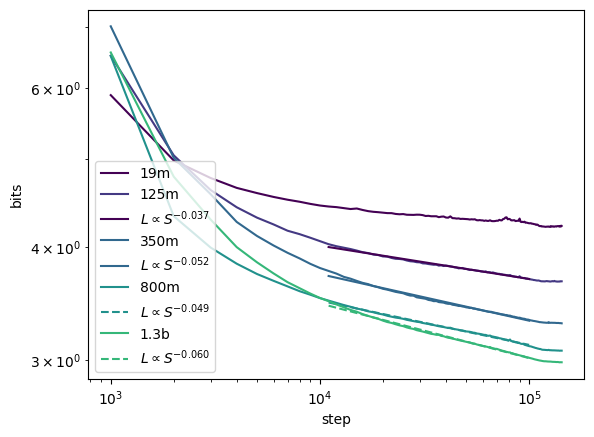

In [27]:
steps = list(range(1000, 144000, 1000))

colors = plt.cm.viridis(np.linspace(0, 1, len(model_names[:-1])))

plt.plot(steps, timeseries19m_mean, label="19m", color=colors[0])
# X = np.log(steps[10:100]).reshape(-1, 1)
# y = np.log(timeseries1_3b_mean[10:100])
# reg = LinearRegression().fit(X, y)
# ys = np.exp(reg.predict(X))
# plt.plot(steps[10:100], ys, label=r"$L \propto S^{" +  f"{reg.coef_[0]:.3f}" + r"}$", color=colors[0])


plt.plot(steps, timeseries125m_mean, label="125m", color=colors[1])
X = np.log(steps[10:100]).reshape(-1, 1)
y = np.log(timeseries125m_mean[10:100])
reg = LinearRegression().fit(X, y)
ys = np.exp(reg.predict(X))
plt.plot(steps[10:100], ys, label=r"$L \propto S^{" +  f"{reg.coef_[0]:.3f}" + r"}$", color=colors[0])

plt.plot(steps, timeseries350m_mean, label="350m", color=colors[2])
X = np.log(steps[10:100]).reshape(-1, 1)
y = np.log(timeseries350m_mean[10:100])
reg = LinearRegression().fit(X, y)
ys = np.exp(reg.predict(X))
plt.plot(steps[10:100], ys, label=r"$L \propto S^{" +  f"{reg.coef_[0]:.3f}" + r"}$", color=colors[2])

plt.plot(steps, timeseries800m_mean, label="800m", color=colors[3])
X = np.log(steps[10:100]).reshape(-1, 1)
y = np.log(timeseries800m_mean[10:100])
reg = LinearRegression().fit(X, y)
ys = np.exp(reg.predict(X))
plt.plot(steps[10:100], ys, label=r"$L \propto S^{" +  f"{reg.coef_[0]:.3f}" + r"}$", color=colors[3], linestyle='dashed')

plt.plot(steps, timeseries1_3b_mean, label="1.3b", color=colors[4])
X = np.log(steps[10:100]).reshape(-1, 1)
y = np.log(timeseries1_3b_mean[10:100])
reg = LinearRegression().fit(X, y)
ys = np.exp(reg.predict(X))
plt.plot(steps[10:100], ys, label=r"$L \propto S^{" +  f"{reg.coef_[0]:.3f}" + r"}$", color=colors[4], linestyle='dashed')

plt.xlabel("step")
plt.ylabel("bits")
plt.xscale("log")
plt.yscale("log")

# perform linear regression on the 1_3b curve (log-log) between steps 10000 and 100000
# to get the slope of the curve. Use sklearn LinearRegression to get the slope
# and intercept of the line of best fit.

plt.legend()

### mean loss integrand over time

  0%|          | 0/143 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Integrand $L \\cdot p(L)$ scaling')

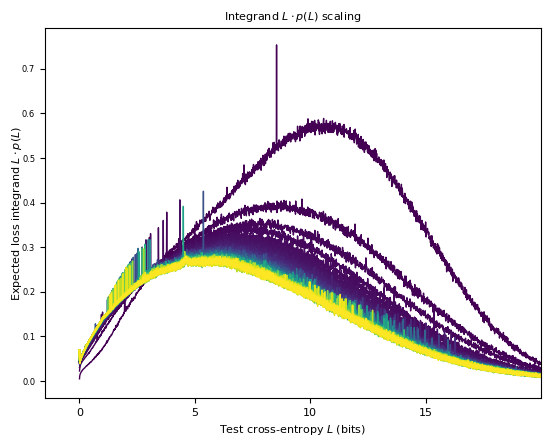

In [31]:
colors = plt.cm.viridis(np.linspace(0, 1, len(steps)))
for i in tqdm(range(len(steps))):
    hist, bin_edges = np.histogram(timeseries1_3b[:, i], bins=3000, range=(0, 30), density=True)
    xs = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(xs, xs * hist, color=colors[i], linewidth=1.0)

# for i in range(len(model_names[:-1])):
#     hist, bin_edges = np.histogram(curves[:, i], bins=1000, range=(0, 18), density=True)
#     xs = (bin_edges[:-1] + bin_edges[1:]) / 2
#     plt.plot(xs, xs * hist, color=colors[i], label=size_names[i], linewidth=1.0)
    # cdf = np.cumsum(hist * np.diff(bin_edges))
    # plt.plot(xs, cdf, color=colors[i], label=size_names[i], linewidth=1.0)

# plt.xlim(0, 0.05)
# plt.ylim(0, 0.6)

plt.xlabel("Test cross-entropy $L$ (bits)", fontsize=8)
# bring ylabel closer to plot (reduce padding)
plt.ylabel("Expected loss integrand $L \cdot p(L)$", fontsize=8, labelpad=-1.5)
plt.xlim(None, 20)

# plt.xlim(0, 0.2)
# plt.ylim(1e-1, 2e1)
# plt.yscale('log')
# plt.xscale('log')
# plt.xlim(0, 10)
# plt.ylim(1e-2, 1e1)
plt.yticks(fontsize=6)
plt.xticks([0, 5, 10, 15], fontsize=8)
# plt.legend(prop={'size': 5})
plt.title("Integrand $L \cdot p(L)$ scaling", fontsize=8)


  0%|          | 0/143 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[Text(0.01, 0, '0.01'),
 Text(0.1, 0, '0.1'),
 Text(1.0, 0, '1'),
 Text(10.0, 0, '10')]

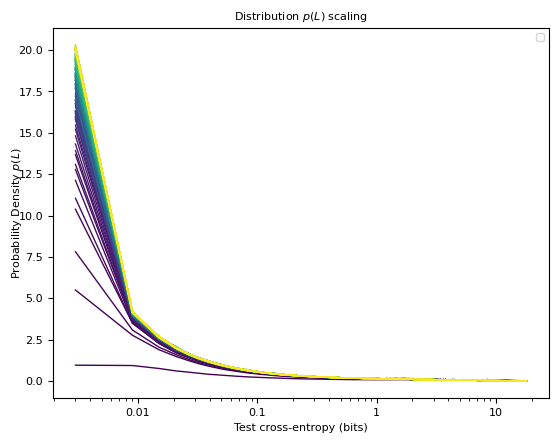

In [34]:
ax = plt.subplot(1, 1, 1)
colors = plt.cm.viridis(np.linspace(0, 1, len(steps)))
for i in tqdm(range(len(steps))):
    hist, bin_edges = np.histogram(timeseries1_3b[:, i], bins=3000, range=(0, 18), density=True)
    xs = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(xs, hist, color=colors[i], linewidth=1.0)

    # cdf = np.cumsum(hist * np.diff(bin_edges))
    # plt.plot(xs, cdf, color=colors[i], label=size_names[i], linewidth=1.0)

# plt.xlim(0, 0.05)
# plt.ylim(0, 0.6)

plt.xlabel("Test cross-entropy (bits)", fontsize=8)
plt.ylabel("Probability Density $p(L)$", fontsize=8, labelpad=-4)
# plt.xlim(0, 0.2)
# plt.ylim(1e-1, 2e1)
# plt.yscale('log')
plt.xscale('log')
# plt.xlim(0, 10)
# plt.ylim(1e-2, 1e1)
plt.legend(prop={'size': 7})
plt.title("Distribution $p(L)$ scaling", fontsize=8)

# yticks = [0.01, 0.1, 1, 10]
# ax.set_yticks(yticks)
# ax.set_yticklabels([str(y) for y in yticks], fontsize=8)
plt.yticks(fontsize=8)
xticks = [0.01, 0.1, 1, 10]
ax.set_xticks(xticks)
ax.set_xticklabels([str(x) for x in xticks], fontsize=8)

### Panel with mean training curves, p(L) over time, and L*p(L) over time

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

/tmp/ipykernel_219129/1706012833.py:118: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


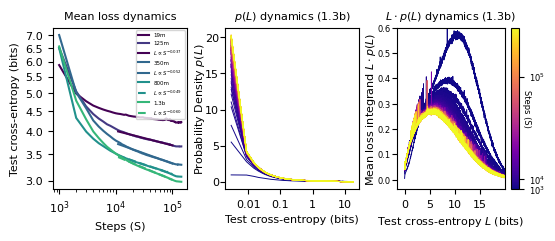

In [53]:
plt.figure(figsize=(5.5, 2.3))

ax = plt.subplot(1, 3, 1)
steps = list(range(1000, 144000, 1000))
colors = plt.cm.viridis(np.linspace(0, 1, len(model_names[:-1])))
plt.plot(steps, timeseries19m_mean, label="19m", color=colors[0])
# X = np.log(steps[10:100]).reshape(-1, 1)
# y = np.log(timeseries1_3b_mean[10:100])
# reg = LinearRegression().fit(X, y)
# ys = np.exp(reg.predict(X))
# plt.plot(steps[10:100], ys, label=r"$L \propto S^{" +  f"{reg.coef_[0]:.3f}" + r"}$", color=colors[0])
plt.plot(steps, timeseries125m_mean, label="125m", color=colors[1])
X = np.log(steps[10:100]).reshape(-1, 1)
y = np.log(timeseries125m_mean[10:100])
reg = LinearRegression().fit(X, y)
ys = np.exp(reg.predict(X))
plt.plot(steps[10:100], ys, label=r"$L \propto S^{" +  f"{reg.coef_[0]:.3f}" + r"}$", color=colors[0])
plt.plot(steps, timeseries350m_mean, label="350m", color=colors[2])
X = np.log(steps[10:100]).reshape(-1, 1)
y = np.log(timeseries350m_mean[10:100])
reg = LinearRegression().fit(X, y)
ys = np.exp(reg.predict(X))
plt.plot(steps[10:100], ys, label=r"$L \propto S^{" +  f"{reg.coef_[0]:.3f}" + r"}$", color=colors[2])
plt.plot(steps, timeseries800m_mean, label="800m", color=colors[3])
X = np.log(steps[10:100]).reshape(-1, 1)
y = np.log(timeseries800m_mean[10:100])
reg = LinearRegression().fit(X, y)
ys = np.exp(reg.predict(X))
plt.plot(steps[10:100], ys, label=r"$L \propto S^{" +  f"{reg.coef_[0]:.3f}" + r"}$", color=colors[3], linestyle='dashed')
plt.plot(steps, timeseries1_3b_mean, label="1.3b", color=colors[4])
X = np.log(steps[10:100]).reshape(-1, 1)
y = np.log(timeseries1_3b_mean[10:100])
reg = LinearRegression().fit(X, y)
ys = np.exp(reg.predict(X))
plt.plot(steps[10:100], ys, label=r"$L \propto S^{" +  f"{reg.coef_[0]:.3f}" + r"}$", color=colors[4], linestyle='dashed')
plt.xlabel("Steps (S)", fontsize=8)
plt.ylabel("Test cross-entropy (bits)", fontsize=8)
plt.xscale("log")
plt.yscale("log")
plt.legend(prop={'size': 4}, loc='upper right')
plt.title("Mean loss dynamics", fontsize=8)


yticks = [3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]
ax.set_yticks(yticks)
ax.set_yticklabels([str(y) for y in yticks], fontsize=8)
# set x tick font size to 8
xticks = [1e3, 1e4, 1e5]
ax.set_xticks(xticks)
ax.set_xticklabels(["$10^3$", "$10^4$", "$10^5$"], fontsize=8)




ax = plt.subplot(1, 3, 2)
colors = plt.cm.plasma(np.linspace(0, 1, len(steps)))
for i in tqdm(range(len(steps))):
    hist, bin_edges = np.histogram(timeseries1_3b[:, i], bins=3000, range=(0, 18), density=True)
    xs = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(xs, hist, color=colors[i], linewidth=0.7)

    # cdf = np.cumsum(hist * np.diff(bin_edges))
    # plt.plot(xs, cdf, color=colors[i], label=size_names[i], linewidth=1.0)

# plt.xlim(0, 0.05)
# plt.ylim(0, 0.6)

plt.xlabel("Test cross-entropy (bits)", fontsize=8)
plt.ylabel("Probability Density $p(L)$", fontsize=8, labelpad=-2)
# plt.xlim(0, 0.2)
# plt.ylim(1e-1, 2e1)
# plt.yscale('log')
plt.xscale('log')
# plt.xlim(0, 10)
# plt.ylim(1e-2, 1e1)
# plt.legend(prop={'size': 7})
plt.title("$p(L)$ dynamics (1.3b)", fontsize=8)

# yticks = [0.01, 0.1, 1, 10]
# ax.set_yticks(yticks)
# ax.set_yticklabels([str(y) for y in yticks], fontsize=8)
ax.tick_params(axis='y', labelsize=8, pad=1)  # Adjust the 'pad' value to bring the tick labels closer or farther from the ticks.
xticks = [0.01, 0.1, 1, 10]
ax.set_xticks(xticks)
ax.set_xticklabels([str(x) for x in xticks], fontsize=8)



ax = plt.subplot(1, 3, 3)
colors = plt.cm.plasma(np.linspace(0, 1, len(steps)))
for i in tqdm(range(len(steps))):
    hist, bin_edges = np.histogram(timeseries1_3b[:, i], bins=3000, range=(0, 30), density=True)
    xs = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(xs, xs * hist, color=colors[i], linewidth=0.7)

# for i in range(len(model_names[:-1])):
#     hist, bin_edges = np.histogram(curves[:, i], bins=1000, range=(0, 18), density=True)
#     xs = (bin_edges[:-1] + bin_edges[1:]) / 2
#     plt.plot(xs, xs * hist, color=colors[i], label=size_names[i], linewidth=1.0)
    # cdf = np.cumsum(hist * np.diff(bin_edges))
    # plt.plot(xs, cdf, color=colors[i], label=size_names[i], linewidth=1.0)

# plt.xlim(0, 0.05)
# plt.ylim(0, 0.6)

plt.xlabel("Test cross-entropy $L$ (bits)", fontsize=8)
# bring ylabel closer to plot (reduce padding)
plt.ylabel("Mean loss integrand $L \cdot p(L)$", fontsize=8, labelpad=0)
plt.xlim(None, 20)
plt.ylim(None, 0.6)

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

norm = Normalize(vmin=min(steps), vmax=max(steps))
sm = ScalarMappable(norm=norm, cmap=plt.cm.plasma)
sm.set_array([])  # You need to set an empty array for the ScalarMappable object.
cbar = plt.colorbar(sm)
cbar.ax.set_ylabel("Steps (S)", rotation=270, labelpad=-10, fontsize=6)
cbar.ax.tick_params(labelsize=6)
ticks = [1e3, 1e4, 1e5]
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"$10^{int(np.log10(t))}$" for t in ticks])


# plt.xlim(0, 0.2)
# plt.ylim(1e-1, 2e1)
# plt.yscale('log')
# plt.xscale('log')
# plt.xlim(0, 10)
# plt.ylim(1e-2, 1e1)
ax.tick_params(axis='y', labelsize=6, pad=1)  # Adjust the 'pad' value to bring the tick labels closer or farther from the ticks.
plt.xticks([0, 5, 10, 15], fontsize=8)
# plt.legend(prop={'size': 5})
plt.title("$L \cdot p(L)$ dynamics (1.3b)", fontsize=8)


plt.subplots_adjust(wspace=0.7)
plt.tight_layout(pad=0.3)

# plt.savefig("../figures/pythia-dynamics-tripanel.pdf")
plt.savefig("../figures/pythia-dynamics-tripanel.png", dpi=300)


# Combined plots

In [12]:
# use only the first 10m because of weirdness
curves = curves = np.load("/om/user/ericjm/results/the-everything-machine/pythia-2/pythia-2.npy")
curves = curves / np.log(2)
curves = curves[:10000000, :]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

/tmp/ipykernel_242669/2730767643.py:232: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


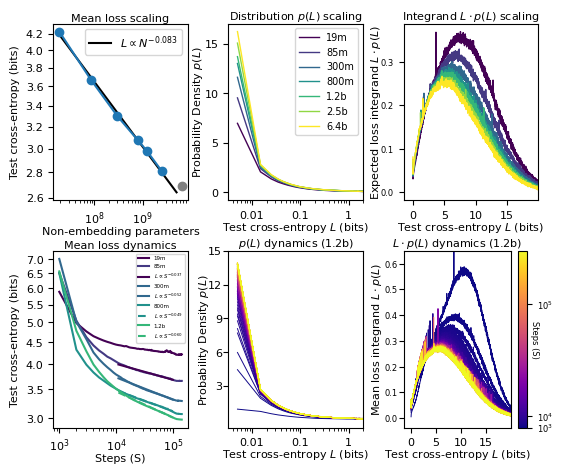

In [30]:
plt.figure(figsize=(5.5, 2.3*2))

ax = plt.subplot(2, 3, 1)

curve_means = curves.mean(axis=0)
plt.plot(no_emb_params[:-1], curve_means[:-1], 'o-')
plt.plot(no_emb_params[-1:], curve_means[-1:], 'o', color='grey')
# plt.plot(with_emb_params, curves.mean(axis=0))
# for model_name in model_names[:-1]:
#     plt.plot([sizes[model_name][0]]*2, [min(curve_means), max(curve_means)], color='red', linestyle='dashed', linewidth=0.5, alpha=0.5)

reg = LinearRegression().fit(np.log(no_emb_params[:-1]).reshape(-1, 1), np.log(curve_means[:-1]))
reg_ys = np.exp(reg.intercept_) * np.power(np.linspace(no_emb_params[0], 2.0*no_emb_params[-2], 10), reg.coef_[0])
plt.plot(np.linspace(no_emb_params[0], 2.0*no_emb_params[-2], 10), reg_ys, color='black', zorder=-10, label=f"$L\propto N^{{{reg.coef_[0]:.3f}}}$")

# plt.xlabel("Non-embedding parameters", fontsize=8)
ax.set_xlabel("Non-embedding parameters", fontsize=8, labelpad=0)
plt.ylabel("Test cross-entropy (bits)", fontsize=8)
plt.legend(prop={'size': 8})

plt.yscale('log')
plt.xscale('log')

yticks = [2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2]
ax.set_yticks(yticks)
ax.set_yticklabels([str(y) for y in yticks], fontsize=8)
# set x tick font size to 8
xticks = [1e8, 1e9]
ax.set_xticks(xticks)
ax.set_xticklabels(["$10^8$", "$10^9$"], fontsize=8)

plt.title("Mean loss scaling", fontsize=8, pad=0)

size_names = {
    0: '19m',
    1: '85m',
    2: '300m',
    3: '800m',
    4: '1.2b',
    5: '2.5b',
    6: '6.4b'
}

size_names_from_model_names = {model_name: size_names[i] for i, model_name in enumerate(model_names[:-1])}

ax = plt.subplot(2, 3, 2)
colors = plt.cm.viridis(np.linspace(0, 1, len(model_names[:-1])))
for i in range(len(model_names[:-1])):
    hist, bin_edges = np.histogram(curves[:, i], bins=3000, range=(0, 30), density=True)
    xs = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(xs, hist, color=colors[i], label=size_names[i], linewidth=1.0)
    # cdf = np.cumsum(hist * np.diff(bin_edges))
    # plt.plot(xs, cdf, color=colors[i], label=size_names[i], linewidth=1.0)

# plt.xlim(0, 0.05)
# plt.ylim(0, 0.6)

# plt.xlabel("Test cross-entropy (bits)", fontsize=8)
ax.set_xlabel("Test cross-entropy $L$ (bits)", fontsize=8, labelpad=0)
plt.ylabel("Probability Density $p(L)$", fontsize=8, labelpad=0)
# plt.xlim(0, 0.2)
# plt.ylim(1e-1, 2e1)
# plt.yscale('log')
plt.xscale('log')
# plt.xlim(0, 10)
# plt.ylim(1e-2, 1e1)
plt.legend(prop={'size': 7})
plt.title("Distribution $p(L)$ scaling", fontsize=8, pad=0)

# yticks = [0.01, 0.1, 1, 10]
# ax.set_yticks(yticks)
# ax.set_yticklabels([str(y) for y in yticks], fontsize=8)
plt.yticks(fontsize=8)
xticks = [0.01, 0.1, 1, 10]
ax.set_xticks(xticks)
ax.set_xticklabels([str(x) for x in xticks], fontsize=8)
plt.xlim(None, 2.0)


ax = plt.subplot(2, 3, 3)
colors = plt.cm.viridis(np.linspace(0, 1, len(model_names[:-1])))
for i in range(len(model_names[:-1])):
    hist, bin_edges = np.histogram(curves[:, i], bins=3000, range=(0, 30), density=True)
    xs = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(xs, xs * hist, color=colors[i], label=size_names[i], linewidth=1.0)
    # cdf = np.cumsum(hist * np.diff(bin_edges))
    # plt.plot(xs, cdf, color=colors[i], label=size_names[i], linewidth=1.0)

plt.xlim(None, 20)
# plt.xlim(0, 0.05)
# plt.ylim(0, 0.6)
# plt.xlabel("Test cross-entropy $L$ (bits)", fontsize=8)
ax.set_xlabel("Test cross-entropy $L$ (bits)", fontsize=8, labelpad=0)
# bring ylabel closer to plot (reduce padding)
plt.ylabel("Expected loss integrand $L \cdot p(L)$", fontsize=8, labelpad=-1.5)


# plt.xlim(0, 0.2)
# plt.ylim(1e-1, 2e1)
# plt.yscale('log')
# plt.xscale('log')
# plt.xlim(0, 10)
# plt.ylim(1e-2, 1e1)
plt.yticks(fontsize=6)
plt.xticks([0, 5, 10, 15], fontsize=8)
# plt.legend(prop={'size': 5})
plt.title("Integrand $L \cdot p(L)$ scaling", fontsize=8, pad=0)




ax = plt.subplot(2, 3, 4)
steps = list(range(1000, 144000, 1000))
colors = plt.cm.viridis(np.linspace(0, 1, len(model_names[:-1])))
plt.plot(steps, timeseries19m_mean, label=size_names_from_model_names['pythia-19m'], color=colors[0])
# X = np.log(steps[10:100]).reshape(-1, 1)
# y = np.log(timeseries1_3b_mean[10:100])
# reg = LinearRegression().fit(X, y)
# ys = np.exp(reg.predict(X))
# plt.plot(steps[10:100], ys, label=r"$L \propto S^{" +  f"{reg.coef_[0]:.3f}" + r"}$", color=colors[0])
plt.plot(steps, timeseries125m_mean, label=size_names_from_model_names['pythia-125m'], color=colors[1])
X = np.log(steps[10:100]).reshape(-1, 1)
y = np.log(timeseries125m_mean[10:100])
reg = LinearRegression().fit(X, y)
ys = np.exp(reg.predict(X))
plt.plot(steps[10:100], ys, label=r"$L \propto S^{" +  f"{reg.coef_[0]:.3f}" + r"}$", color=colors[0])
plt.plot(steps, timeseries350m_mean, label=size_names_from_model_names['pythia-350m'], color=colors[2])
X = np.log(steps[10:100]).reshape(-1, 1)
y = np.log(timeseries350m_mean[10:100])
reg = LinearRegression().fit(X, y)
ys = np.exp(reg.predict(X))
plt.plot(steps[10:100], ys, label=r"$L \propto S^{" +  f"{reg.coef_[0]:.3f}" + r"}$", color=colors[2])
plt.plot(steps, timeseries800m_mean, label=size_names_from_model_names['pythia-800m'], color=colors[3])
X = np.log(steps[10:100]).reshape(-1, 1)
y = np.log(timeseries800m_mean[10:100])
reg = LinearRegression().fit(X, y)
ys = np.exp(reg.predict(X))
plt.plot(steps[10:100], ys, label=r"$L \propto S^{" +  f"{reg.coef_[0]:.3f}" + r"}$", color=colors[3], linestyle='dashed')
plt.plot(steps, timeseries1_3b_mean, label=size_names_from_model_names['pythia-1.3b'], color=colors[4])
X = np.log(steps[10:100]).reshape(-1, 1)
y = np.log(timeseries1_3b_mean[10:100])
reg = LinearRegression().fit(X, y)
ys = np.exp(reg.predict(X))
plt.plot(steps[10:100], ys, label=r"$L \propto S^{" +  f"{reg.coef_[0]:.3f}" + r"}$", color=colors[4], linestyle='dashed')
# plt.xlabel("Steps (S)", fontsize=8)
ax.set_xlabel("Steps (S)", fontsize=8, labelpad=0)
plt.ylabel("Test cross-entropy (bits)", fontsize=8)
plt.xscale("log")
plt.yscale("log")
plt.legend(prop={'size': 4}, loc='upper right')
plt.title("Mean loss dynamics", fontsize=8, pad=0)


yticks = [3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]
ax.set_yticks(yticks)
ax.set_yticklabels([str(y) for y in yticks], fontsize=8)
# set x tick font size to 8
xticks = [1e3, 1e4, 1e5]
ax.set_xticks(xticks)
ax.set_xticklabels(["$10^3$", "$10^4$", "$10^5$"], fontsize=8)




ax = plt.subplot(2, 3, 5)
colors = plt.cm.plasma(np.linspace(0, 1, len(steps)))
for i in tqdm(range(len(steps))):
    hist, bin_edges = np.histogram(timeseries1_3b[:, i], bins=3000, range=(0, 30), density=True)
    xs = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(xs, hist, color=colors[i], linewidth=0.7)

    # cdf = np.cumsum(hist * np.diff(bin_edges))
    # plt.plot(xs, cdf, color=colors[i], label=size_names[i], linewidth=1.0)

# plt.xlim(0, 0.05)
# plt.ylim(0, 0.6)

# plt.xlabel("Test cross-entropy (bits)", fontsize=8)
# plt.xlabel("Test cross-entropy $L$ (bits)", fontsize=8)
ax.set_xlabel("Test cross-entropy $L$ (bits)", fontsize=8, labelpad=0)
plt.ylabel("Probability Density $p(L)$", fontsize=8, labelpad=-2)
# plt.xlim(0, 0.2)
# plt.ylim(1e-1, 2e1)
# plt.yscale('log')
plt.xscale('log')
# plt.xlim(0, 10)
# plt.ylim(1e-2, 1e1)
# plt.legend(prop={'size': 7})
plt.title("$p(L)$ dynamics (1.2b)", fontsize=8, pad=0)

# yticks = [0.01, 0.1, 1, 10]
# ax.set_yticks(yticks)
# ax.set_yticklabels([str(y) for y in yticks], fontsize=8)
ax.tick_params(axis='y', labelsize=8, pad=1)  # Adjust the 'pad' value to bring the tick labels closer or farther from the ticks.
xticks = [0.01, 0.1, 1, 10]
ax.set_xticks(xticks)
ax.set_xticklabels([str(x) for x in xticks], fontsize=8)
plt.yticks([3, 6, 9, 12, 15], [3, 6, 9, 12, 15], fontsize=8)
plt.xlim(None, 2.0)


ax = plt.subplot(2, 3, 6)
colors = plt.cm.plasma(np.linspace(0, 1, len(steps)))
for i in tqdm(range(len(steps))):
    hist, bin_edges = np.histogram(timeseries1_3b[:, i], bins=3000, range=(0, 30), density=True)
    xs = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(xs, xs * hist, color=colors[i], linewidth=0.7)

# for i in range(len(model_names[:-1])):
#     hist, bin_edges = np.histogram(curves[:, i], bins=1000, range=(0, 18), density=True)
#     xs = (bin_edges[:-1] + bin_edges[1:]) / 2
#     plt.plot(xs, xs * hist, color=colors[i], label=size_names[i], linewidth=1.0)
    # cdf = np.cumsum(hist * np.diff(bin_edges))
    # plt.plot(xs, cdf, color=colors[i], label=size_names[i], linewidth=1.0)

# plt.xlim(0, 0.05)
# plt.ylim(0, 0.6)

# plt.xlabel("Test cross-entropy $L$ (bits)", fontsize=8)
ax.set_xlabel("Test cross-entropy $L$ (bits)", fontsize=8, labelpad=0)
# bring ylabel closer to plot (reduce padding)
plt.ylabel("Mean loss integrand $L \cdot p(L)$", fontsize=8, labelpad=0)
plt.xlim(None, 20)
plt.ylim(None, 0.65)

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

norm = Normalize(vmin=min(steps), vmax=max(steps))
sm = ScalarMappable(norm=norm, cmap=plt.cm.plasma)
sm.set_array([])  # You need to set an empty array for the ScalarMappable object.
cbar = plt.colorbar(sm)
cbar.ax.set_ylabel("Steps (S)", rotation=270, labelpad=-10, fontsize=6)
cbar.ax.tick_params(labelsize=6)
ticks = [1e3, 1e4, 1e5]
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"$10^{int(np.log10(t))}$" for t in ticks])


# plt.xlim(0, 0.2)
# plt.ylim(1e-1, 2e1)
# plt.yscale('log')
# plt.xscale('log')
# plt.xlim(0, 10)
# plt.ylim(1e-2, 1e1)
ax.tick_params(axis='y', labelsize=6, pad=1)  # Adjust the 'pad' value to bring the tick labels closer or farther from the ticks.
plt.xticks([0, 5, 10, 15], fontsize=8)
# plt.legend(prop={'size': 5})
plt.title("$L \cdot p(L)$ dynamics (1.2b)", fontsize=8, pad=0)



# plt.savefig("../figures/pythia-dynamics-tripanel.pdf")
# plt.savefig("../figures/pythia-dynamics-tripanel.png", dpi=300)



plt.subplots_adjust(wspace=0.3)
# plt.subplots_adjust(hspace=3.0)
plt.tight_layout(pad=0.2)

plt.savefig("../figures/pythia-scaling-sixpanel.png", dpi=300)



In [27]:
i = 10000000-1
print(timeseries1_3b[i, -1])
print(curves[i, 4])

0.9425961
0.9425961


### Figure with simple scaling law distribution over losses

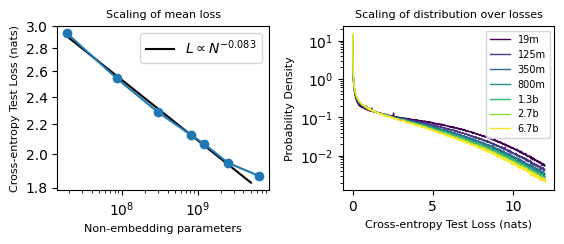

In [9]:
plt.figure(figsize=(5.5, 2.3))

ax = plt.subplot(1, 2, 1)

curve_means = curves.mean(axis=0)
plt.plot(no_emb_params, curve_means, 'o-')
# plt.plot(with_emb_params, curves.mean(axis=0))
# for model_name in model_names[:-1]:
#     plt.plot([sizes[model_name][0]]*2, [min(curve_means), max(curve_means)], color='red', linestyle='dashed', linewidth=0.5, alpha=0.5)

reg = LinearRegression().fit(np.log(no_emb_params[:-1]).reshape(-1, 1), np.log(curve_means[:-1]))
reg_ys = np.exp(reg.intercept_) * np.power(np.linspace(no_emb_params[0], 2.0*no_emb_params[-2], 10), reg.coef_[0])
plt.plot(np.linspace(no_emb_params[0], 2.0*no_emb_params[-2], 10), reg_ys, color='black', zorder=-10, label=f"$L\propto N^{{{reg.coef_[0]:.3f}}}$")

plt.yscale('log')
plt.xscale('log')
plt.xlabel("Non-embedding parameters", fontsize=8)
plt.ylabel("Cross-entropy Test Loss (nats)", fontsize=8)
plt.legend()

yticks = [1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0]
ax.set_yticks(yticks)
ax.set_yticklabels([str(y) for y in yticks])

plt.title("Scaling of mean loss", fontsize=8)


size_names = {
    0: '19m',
    1: '85m',
    2: '300m',
    3: '800m',
    4: '1.2b',
    5: '2.5b',
    6: '6.4b'
}

ax = plt.subplot(1, 2, 2)
colors = plt.cm.viridis(np.linspace(0, 1, len(model_names[:-1])))
for i in range(len(model_names[:-1])):
    hist, bin_edges = np.histogram(curves[:, i], bins=1000, range=(0, 12), density=True)
    xs = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(xs, hist, color=colors[i], label=size_names[i], linewidth=1.0)

# plt.xlim(0, 0.05)
# plt.ylim(0, 0.6)

plt.xlabel("Cross-entropy Test Loss (nats)", fontsize=8)
plt.ylabel("Probability Density", fontsize=8)
# plt.xlim(0, 0.2)
# plt.ylim(1e-1, 2e1)
plt.yscale('log')
# plt.xlim(0, 10)
# plt.ylim(1e-2, 1e1)
plt.legend(prop={'size': 7})
plt.title("Scaling of distribution over losses", fontsize=8)

# yticks = [0.01, 0.1, 1, 10]
# ax.set_yticks(yticks)
# ax.set_yticklabels([str(y) for y in yticks])

plt.subplots_adjust(wspace=1.7)
plt.tight_layout(pad=0.2)

# plt.savefig("../figures/scaling-mean-and-distribution.pdf")



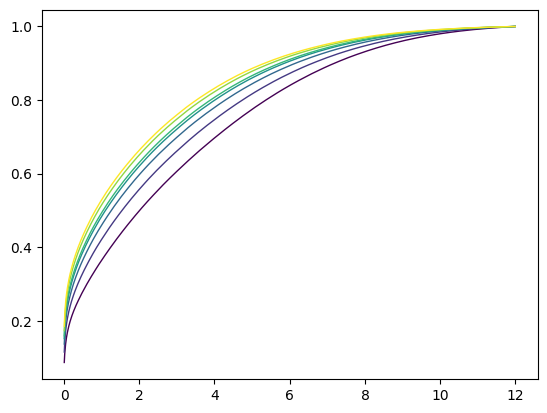

In [12]:
for i in range(len(model_names[:-1])):
    hist, bin_edges = np.histogram(curves[:, i], bins=1000, range=(0, 12), density=True)
    xs = (bin_edges[:-1] + bin_edges[1:]) / 2
    cdf = np.cumsum(hist * np.diff(bin_edges))
    plt.plot(xs, cdf, color=colors[i], label=size_names[i], linewidth=1.0)

### Study Convergence to mean loss

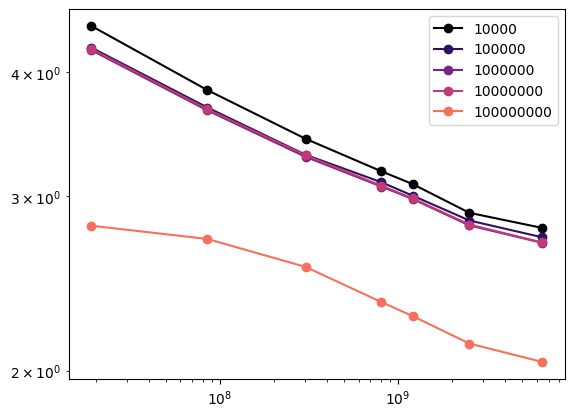

In [14]:
n_samples = [int(10**i) for i in [4, 5, 6, 7, 8]]
colors = plt.cm.magma(np.linspace(0, 0.7, len(n_samples)))
for samples in n_samples:
    curve_means = curves[:samples, :].mean(axis=0)
    plt.plot(no_emb_params, curve_means, 'o-', color=colors[n_samples.index(samples)], label=f"{samples}")

plt.xscale('log')
plt.yscale('log')
plt.legend()

Text(0.5, 1.0, 'Mean loss scaling')

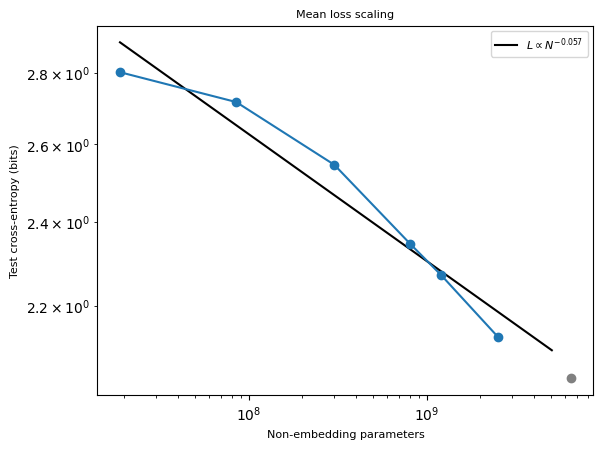

In [21]:
curve_means = curves[00000000:100000000, :].mean(axis=0)


plt.plot(no_emb_params[:-1], curve_means[:-1], 'o-')
plt.plot(no_emb_params[-1:], curve_means[-1:], 'o', color='grey')
# plt.plot(with_emb_params, curves.mean(axis=0))
# for model_name in model_names[:-1]:
#     plt.plot([sizes[model_name][0]]*2, [min(curve_means), max(curve_means)], color='red', linestyle='dashed', linewidth=0.5, alpha=0.5)

reg = LinearRegression().fit(np.log(no_emb_params[:-1]).reshape(-1, 1), np.log(curve_means[:-1]))
reg_ys = np.exp(reg.intercept_) * np.power(np.linspace(no_emb_params[0], 2.0*no_emb_params[-2], 10), reg.coef_[0])
plt.plot(np.linspace(no_emb_params[0], 2.0*no_emb_params[-2], 10), reg_ys, color='black', zorder=-10, label=f"$L\propto N^{{{reg.coef_[0]:.3f}}}$")

plt.xlabel("Non-embedding parameters", fontsize=8)
plt.ylabel("Test cross-entropy (bits)", fontsize=8)
plt.legend(prop={'size': 8})

plt.yscale('log')
plt.xscale('log')

# yticks = [2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2]
# ax.set_yticks(yticks)
# ax.set_yticklabels([str(y) for y in yticks], fontsize=8)
# # set x tick font size to 8
# xticks = [1e8, 1e9]
# ax.set_xticks(xticks)
# ax.set_xticklabels(["$10^8$", "$10^9$"], fontsize=8)

plt.title("Mean loss scaling", fontsize=8)

In [2]:
curves = curves = np.load("/om/user/ericjm/results/the-everything-machine/pythia-2/pythia-2.npy")
curves = curves / np.log(2)
curves = curves[:10000000, :]

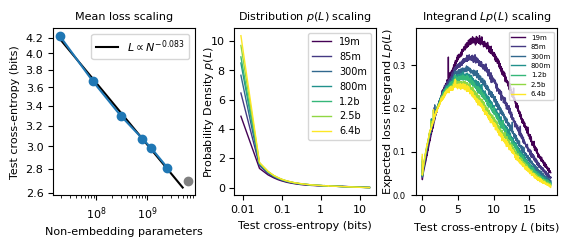

In [8]:
plt.figure(figsize=(5.5, 2.3))

ax = plt.subplot(1, 3, 1)

curve_means = curves.mean(axis=0)
plt.plot(no_emb_params[:-1], curve_means[:-1], 'o-')
plt.plot(no_emb_params[-1:], curve_means[-1:], 'o', color='grey')
# plt.plot(with_emb_params, curves.mean(axis=0))
# for model_name in model_names[:-1]:
#     plt.plot([sizes[model_name][0]]*2, [min(curve_means), max(curve_means)], color='red', linestyle='dashed', linewidth=0.5, alpha=0.5)

reg = LinearRegression().fit(np.log(no_emb_params[:-1]).reshape(-1, 1), np.log(curve_means[:-1]))
reg_ys = np.exp(reg.intercept_) * np.power(np.linspace(no_emb_params[0], 2.0*no_emb_params[-2], 10), reg.coef_[0])
plt.plot(np.linspace(no_emb_params[0], 2.0*no_emb_params[-2], 10), reg_ys, color='black', zorder=-10, label=f"$L\propto N^{{{reg.coef_[0]:.3f}}}$")

plt.xlabel("Non-embedding parameters", fontsize=8)
plt.ylabel("Test cross-entropy (bits)", fontsize=8)
plt.legend(prop={'size': 8})

plt.yscale('log')
plt.xscale('log')

yticks = [2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2]
ax.set_yticks(yticks)
ax.set_yticklabels([str(y) for y in yticks], fontsize=8)
# set x tick font size to 8
xticks = [1e8, 1e9]
ax.set_xticks(xticks)
ax.set_xticklabels(["$10^8$", "$10^9$"], fontsize=8)

plt.title("Mean loss scaling", fontsize=8)

size_names = {
    0: '19m',
    1: '85m',
    2: '300m',
    3: '800m',
    4: '1.2b',
    5: '2.5b',
    6: '6.4b'
}

ax = plt.subplot(1, 3, 2)
colors = plt.cm.viridis(np.linspace(0, 1, len(model_names[:-1])))
for i in range(len(model_names[:-1])):
    hist, bin_edges = np.histogram(curves[:, i], bins=1000, range=(0, 18), density=True)
    xs = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(xs, hist, color=colors[i], label=size_names[i], linewidth=1.0)
    # cdf = np.cumsum(hist * np.diff(bin_edges))
    # plt.plot(xs, cdf, color=colors[i], label=size_names[i], linewidth=1.0)

# plt.xlim(0, 0.05)
# plt.ylim(0, 0.6)

plt.xlabel("Test cross-entropy (bits)", fontsize=8)
plt.ylabel("Probability Density $p(L)$", fontsize=8, labelpad=-4)
# plt.xlim(0, 0.2)
# plt.ylim(1e-1, 2e1)
# plt.yscale('log')
plt.xscale('log')
# plt.xlim(0, 10)
# plt.ylim(1e-2, 1e1)
plt.legend(prop={'size': 7})
plt.title("Distribution $p(L)$ scaling", fontsize=8)

# yticks = [0.01, 0.1, 1, 10]
# ax.set_yticks(yticks)
# ax.set_yticklabels([str(y) for y in yticks], fontsize=8)
plt.yticks(fontsize=8)
xticks = [0.01, 0.1, 1, 10]
ax.set_xticks(xticks)
ax.set_xticklabels([str(x) for x in xticks], fontsize=8)


ax = plt.subplot(1, 3, 3)
colors = plt.cm.viridis(np.linspace(0, 1, len(model_names[:-1])))
for i in range(len(model_names[:-1])):
    hist, bin_edges = np.histogram(curves[:, i], bins=1000, range=(0, 18), density=True)
    xs = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(xs, xs * hist, color=colors[i], label=size_names[i], linewidth=1.0)
    # cdf = np.cumsum(hist * np.diff(bin_edges))
    # plt.plot(xs, cdf, color=colors[i], label=size_names[i], linewidth=1.0)

# plt.xlim(0, 0.05)
# plt.ylim(0, 0.6)

plt.xlabel("Test cross-entropy $L$ (bits)", fontsize=8)
# bring ylabel closer to plot (reduce padding)
plt.ylabel("Expected loss integrand $L p(L)$", fontsize=8, labelpad=-1.5)


# plt.xlim(0, 0.2)
# plt.ylim(1e-1, 2e1)
# plt.yscale('log')
# plt.xscale('log')
# plt.xlim(0, 10)
# plt.ylim(1e-2, 1e1)
plt.yticks(fontsize=6)
plt.xticks([0, 5, 10, 15], fontsize=8)
plt.legend(prop={'size': 5})
plt.title("Integrand $L p(L)$ scaling", fontsize=8)


plt.subplots_adjust(wspace=0.7)
plt.tight_layout(pad=0.1)

plt.savefig("../figures/pythia-scaling-tripanel.png", dpi=350)



In [39]:
curves = curves = np.load("/om/user/ericjm/results/the-everything-machine/pythia-2/pythia-2.npy")
curves = curves / np.log(2)
curves = curves[:100000000, :]

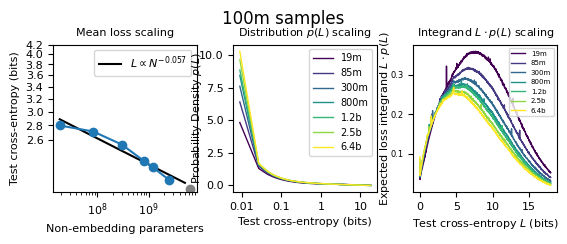

In [42]:
plt.figure(figsize=(5.5, 2.3))

ax = plt.subplot(1, 3, 1)

curve_means = curves.mean(axis=0)
plt.plot(no_emb_params[:-1], curve_means[:-1], 'o-')
plt.plot(no_emb_params[-1:], curve_means[-1:], 'o', color='grey')
# plt.plot(with_emb_params, curves.mean(axis=0))
# for model_name in model_names[:-1]:
#     plt.plot([sizes[model_name][0]]*2, [min(curve_means), max(curve_means)], color='red', linestyle='dashed', linewidth=0.5, alpha=0.5)

reg = LinearRegression().fit(np.log(no_emb_params[:-1]).reshape(-1, 1), np.log(curve_means[:-1]))
reg_ys = np.exp(reg.intercept_) * np.power(np.linspace(no_emb_params[0], 2.0*no_emb_params[-2], 10), reg.coef_[0])
plt.plot(np.linspace(no_emb_params[0], 2.0*no_emb_params[-2], 10), reg_ys, color='black', zorder=-10, label=f"$L\propto N^{{{reg.coef_[0]:.3f}}}$")

plt.xlabel("Non-embedding parameters", fontsize=8)
plt.ylabel("Test cross-entropy (bits)", fontsize=8)
plt.legend(prop={'size': 8})

plt.yscale('log')
plt.xscale('log')

yticks = [2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2]
ax.set_yticks(yticks)
ax.set_yticklabels([str(y) for y in yticks], fontsize=8)
# set x tick font size to 8
xticks = [1e8, 1e9]
ax.set_xticks(xticks)
ax.set_xticklabels(["$10^8$", "$10^9$"], fontsize=8)

plt.title("Mean loss scaling", fontsize=8)

size_names = {
    0: '19m',
    1: '85m',
    2: '300m',
    3: '800m',
    4: '1.2b',
    5: '2.5b',
    6: '6.4b'
}

ax = plt.subplot(1, 3, 2)
colors = plt.cm.viridis(np.linspace(0, 1, len(model_names[:-1])))
for i in range(len(model_names[:-1])):
    hist, bin_edges = np.histogram(curves[:, i], bins=1000, range=(0, 18), density=True)
    xs = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(xs, hist, color=colors[i], label=size_names[i], linewidth=1.0)
    # cdf = np.cumsum(hist * np.diff(bin_edges))
    # plt.plot(xs, cdf, color=colors[i], label=size_names[i], linewidth=1.0)

# plt.xlim(0, 0.05)
# plt.ylim(0, 0.6)

plt.xlabel("Test cross-entropy (bits)", fontsize=8)
plt.ylabel("Probability Density $p(L)$", fontsize=8, labelpad=-4)
# plt.xlim(0, 0.2)
# plt.ylim(1e-1, 2e1)
# plt.yscale('log')
plt.xscale('log')
# plt.xlim(0, 10)
# plt.ylim(1e-2, 1e1)
plt.legend(prop={'size': 7})
plt.title("Distribution $p(L)$ scaling", fontsize=8)

# yticks = [0.01, 0.1, 1, 10]
# ax.set_yticks(yticks)
# ax.set_yticklabels([str(y) for y in yticks], fontsize=8)
plt.yticks(fontsize=8)
xticks = [0.01, 0.1, 1, 10]
ax.set_xticks(xticks)
ax.set_xticklabels([str(x) for x in xticks], fontsize=8)


ax = plt.subplot(1, 3, 3)
colors = plt.cm.viridis(np.linspace(0, 1, len(model_names[:-1])))
for i in range(len(model_names[:-1])):
    hist, bin_edges = np.histogram(curves[:, i], bins=1000, range=(0, 18), density=True)
    xs = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(xs, xs * hist, color=colors[i], label=size_names[i], linewidth=1.0)
    # cdf = np.cumsum(hist * np.diff(bin_edges))
    # plt.plot(xs, cdf, color=colors[i], label=size_names[i], linewidth=1.0)

# plt.xlim(0, 0.05)
# plt.ylim(0, 0.6)

plt.xlabel("Test cross-entropy $L$ (bits)", fontsize=8)
# bring ylabel closer to plot (reduce padding)
plt.ylabel("Expected loss integrand $L \cdot p(L)$", fontsize=8, labelpad=-1.5)


# plt.xlim(0, 0.2)
# plt.ylim(1e-1, 2e1)
# plt.yscale('log')
# plt.xscale('log')
# plt.xlim(0, 10)
# plt.ylim(1e-2, 1e1)
plt.yticks(fontsize=6)
plt.xticks([0, 5, 10, 15], fontsize=8)
plt.legend(prop={'size': 5})
plt.title("Integrand $L \cdot p(L)$ scaling", fontsize=8)


plt.subplots_adjust(wspace=0.7)
plt.suptitle("100m samples")
plt.tight_layout(pad=0.1)


# plt.savefig("../figures/pythia-scaling-tripanel.pdf")



In [10]:
hist, bin_edges = np.histogram(curves[:, 0], bins=1000, range=(0, 18), density=True)
xs = (bin_edges[:-1] + bin_edges[1:]) / 2

In [12]:
np.sum(hist * np.diff(bin_edges))

1.0

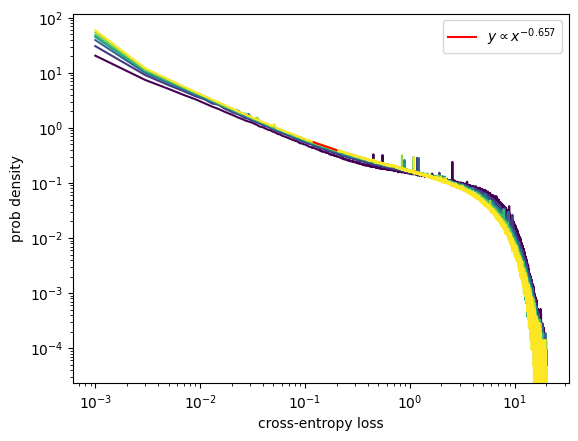

In [16]:
colors = plt.cm.viridis(np.linspace(0, 1, len(model_names[:-1])))
for i in range(len(model_names[:-1])):
    hist, bin_edges = np.histogram(curves[:, i], bins=10000, range=(0, 20), density=True)
    xs = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(xs, hist, color=colors[i])


i0, i1 = 60, 100
reg = LinearRegression().fit(np.log(xs[i0:i1]).reshape(-1, 1), np.log(hist[i0:i1]))
reg_ys = np.exp(reg.intercept_) * np.power(xs[i0:i1], reg.coef_[0])
plt.plot(xs[i0:i1], reg_ys, color='red', zorder=10, label=f"$y\propto x^{{{reg.coef_[0]:.3f}}}$")


plt.yscale('log')
plt.xscale('log')
# plt.xscale('log')
# plt.xlim(0, 0.05)
# plt.ylim(0, 0.6)

plt.xlabel("cross-entropy loss")
plt.ylabel("prob density")
# plt.xlim(0, 0.2)
# plt.ylim(1e-1, 2e1)
plt.legend()

Text(0, 0.5, 'contribution to mean loss')

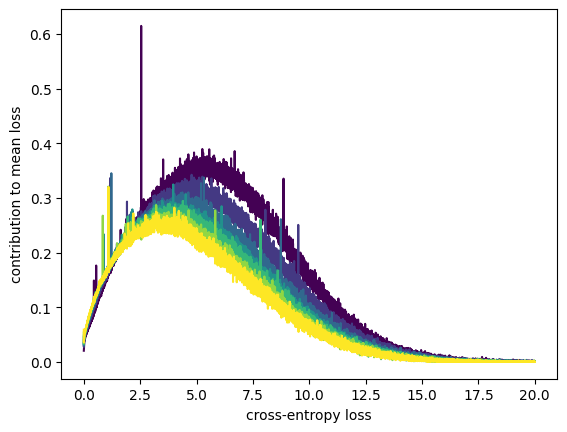

In [17]:
colors = plt.cm.viridis(np.linspace(0, 1, len(model_names[:-1])))
for i in range(len(model_names[:-1])):
    hist, bin_edges = np.histogram(curves[:, i], bins=10000, range=(0, 20), density=True)
    xs = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(xs, xs * hist, color=colors[i])

# plt.yscale('log')
# plt.xscale('log')
# plt.xscale('log')
# plt.xlim(0, 0.05)
# plt.ylim(0, 0.6)

plt.xlabel("cross-entropy loss")
plt.ylabel("contribution to mean loss")
# plt.xlim(0, 0.2)
# plt.ylim(1e-1, 2e1)

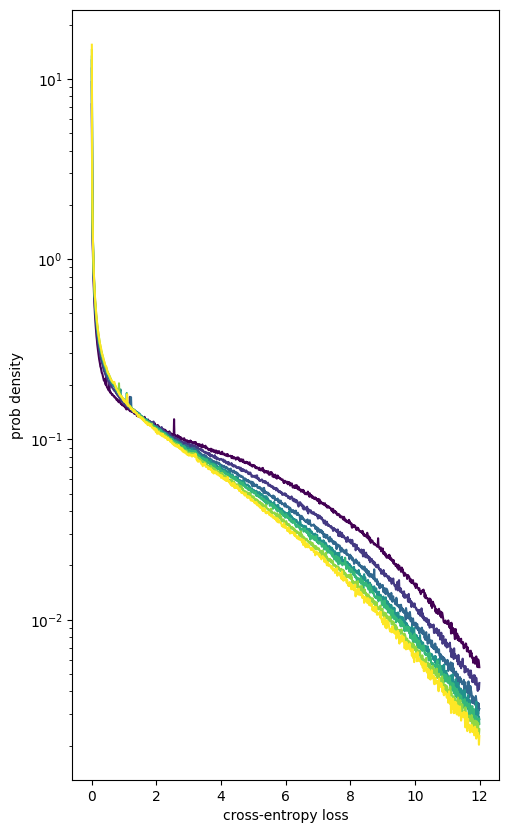

In [10]:
plt.figure(figsize=(5.5, 10))

colors = plt.cm.viridis(np.linspace(0, 1, len(model_names[:-1])))
for i in range(len(model_names[:-1])):
    hist, bin_edges = np.histogram(curves[:, i], bins=1000, range=(0, 12), density=True)
    xs = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(xs, hist, color=colors[i])

# plt.xlim(0, 0.05)
# plt.ylim(0, 0.6)

plt.xlabel("cross-entropy loss")
plt.ylabel("prob density")
# plt.xlim(0, 0.2)
# plt.ylim(1e-1, 2e1)
plt.yscale('log')
# plt.xlim(0, 10)
# plt.ylim(1e-2, 1e1)

# plt.plot([1.69, 1.69], [1e-2, 3e-1])
# plt.xlim(0.5, 2)
# plt.ylim(1e-1, 3e-1)

In [11]:
hists = dict()
for i in range(len(model_names[:-1])):
    hist, bin_edges = np.histogram(curves[:, i], bins=1000, range=(0, 12), density=True)
    hists[i] = hist

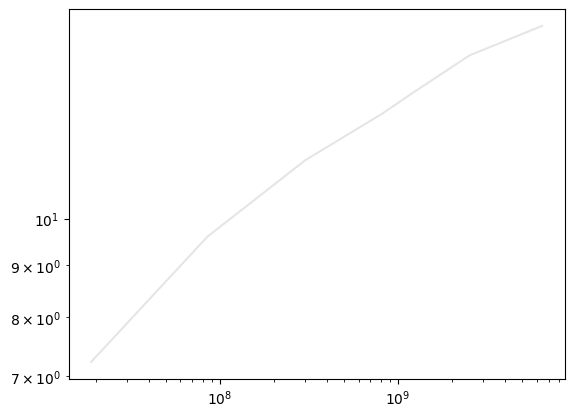

In [21]:
j = 0
plt.plot(no_emb_params, [hists[i][j] for i in range(len(model_names[:-1]))], color='black', alpha=0.1)
plt.xscale('log')
plt.yscale('log')

In [45]:
starts = curves[:, 1]
diffs = curves[:, 2] - curves[:, 1]

In [101]:
hist, xedges, yedges = np.histogram2d(starts, diffs, bins=500)

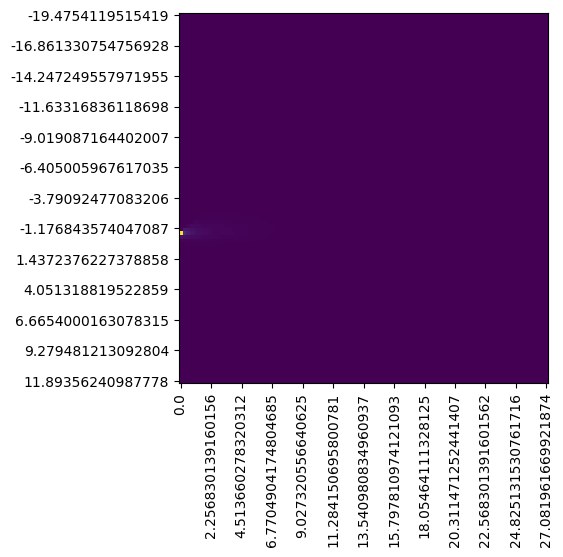

In [88]:
_ = plt.imshow(hist.T)
_ = plt.xticks(np.linspace(0, 99, len(xedges[::8])), labels=xedges[::8], rotation=90)
_ = plt.yticks(np.linspace(0, 99, len(yedges[::8])), labels=yedges[::8], rotation=0)
# plt.xlim(0, 5)
# plt.ylim(-1, 1)

In [102]:
values = sorted(hist.flatten().tolist(), reverse=True)
xs = list(range(1, len(values)+1))

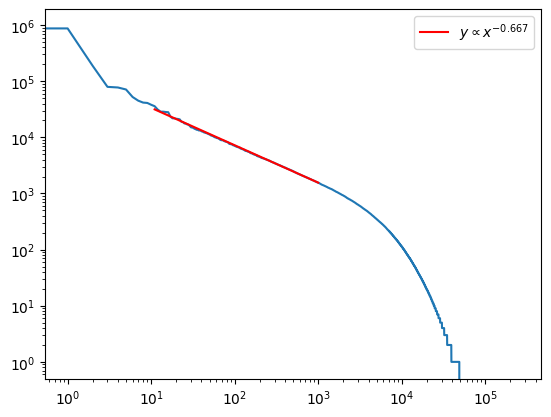

In [104]:
plt.plot(values)

i0, i1 = 10, 1000
reg = LinearRegression().fit(np.log(xs[i0:i1]).reshape(-1, 1), np.log(values[i0:i1]))
reg_ys = np.exp(reg.intercept_) * np.power(xs[i0:i1], reg.coef_[0])
plt.plot(xs[i0:i1], reg_ys, color='red', zorder=10, label=f"$y\propto x^{{{reg.coef_[0]:.3f}}}$")

plt.xscale('log')
plt.yscale('log')
plt.legend()

### When tokens have zero loss, do they remain at zero loss with larger models?

In [13]:
zeros_results = defaultdict(list)
persistently_zeros_results = defaultdict(list)
for i in tqdm(range(curves.shape[0])):
    if np.any(curves[i, :-1] < 0.3):
        init_j = min(j for j in range(curves.shape[1]) if curves[i, j] < 0.3)
        zeros_results[model_names[init_j]].append(i)
        if np.all(curves[i, init_j:] < 0.3):
            persistently_zeros_results[model_names[init_j]].append(i)

  0%|          | 0/10658635 [00:00<?, ?it/s]

In [14]:
for j in range(curves.shape[1]-1):
    mn = model_names[j]
    print("{:.2f}% of tokens which first reach < 0.3 nats at {} remain < 0.3".format(100 * len(persistently_zeros_results[mn]) / len(zeros_results[mn]), mn))
    

88.86% of tokens which first reach < 0.3 nats at pythia-19m remain < 0.3
70.36% of tokens which first reach < 0.3 nats at pythia-125m remain < 0.3
62.93% of tokens which first reach < 0.3 nats at pythia-350m remain < 0.3
53.25% of tokens which first reach < 0.3 nats at pythia-800m remain < 0.3
55.97% of tokens which first reach < 0.3 nats at pythia-1.3b remain < 0.3
66.80% of tokens which first reach < 0.3 nats at pythia-2.7b remain < 0.3


### Look at distribution over changes in loss

(-0.5, 0.5)

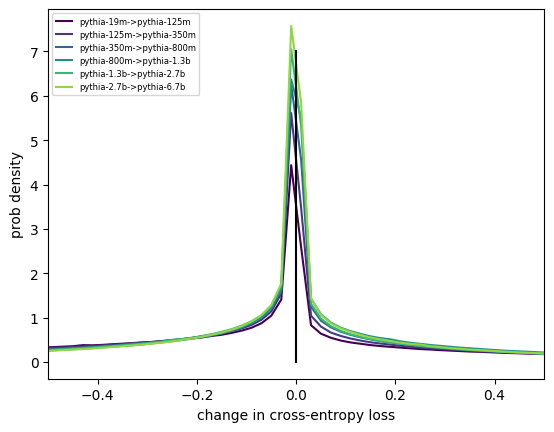

In [23]:
colors = plt.cm.viridis(np.linspace(0, 1, len(model_names[:-1])))
for i in range(len(model_names[:-1])-1):
    diffs = curves[:, i+1] - curves[:, i]
    hist, bin_edges = np.histogram(diffs, bins=1000, range=(-10, 10), density=True)
    xs = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(xs, hist, color=colors[i], label=f"{model_names[i]}->{model_names[i+1]}")
# plt.yscale('log')
# plt.xscale('log')
# plt.xscale('log')
# plt.xlim(0, 0.05)
# plt.ylim(0, 0.6)
plt.plot([0, 0], [0, 7], color='black')
plt.xlabel("change in cross-entropy loss")
plt.ylabel("prob density")
plt.legend(loc='upper left', prop={'size': 6})
plt.xlim(-5e-1, 5e-1)
# plt.xlim(0, 0.2)
# plt.ylim(-5e-1, 5e-1)

##### What if we exclude tokens which were already zero?

In [25]:
tokens_which_have_zero_loss_for_model = defaultdict(list)
for i in tqdm(range(curves.shape[0])):
    for j in range(curves.shape[1]): 
        if curves[i, j] < 0.3:
            tokens_which_have_zero_loss_for_model[model_names[j]].append(i)


  0%|          | 0/10658635 [00:00<?, ?it/s]

(-0.5, 0.5)

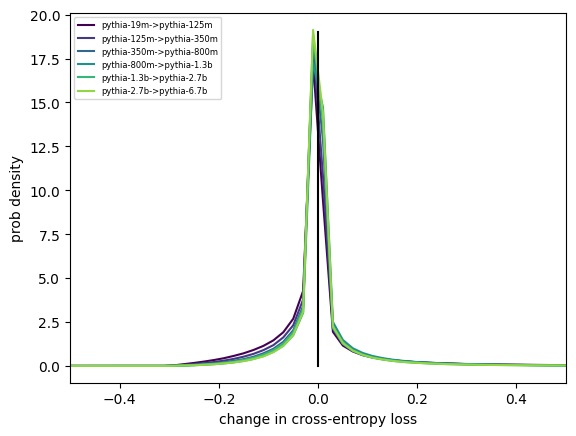

In [27]:
colors = plt.cm.viridis(np.linspace(0, 1, len(model_names[:-1])))
for i in range(len(model_names[:-1])-1):
    exclude_tokens = tokens_which_have_zero_loss_for_model[model_names[i]]
    diffs = curves[exclude_tokens, i+1] - curves[exclude_tokens, i]
    hist, bin_edges = np.histogram(diffs, bins=1000, range=(-10, 10), density=True)
    xs = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(xs, hist, color=colors[i], label=f"{model_names[i]}->{model_names[i+1]}")
# plt.yscale('log')
# plt.xscale('log')
# plt.xscale('log')
# plt.xlim(0, 0.05)
# plt.ylim(0, 0.6)
plt.plot([0, 0], [0, 19], color='black')
plt.xlabel("change in cross-entropy loss")
plt.ylabel("prob density")
plt.legend(loc='upper left', prop={'size': 6})
plt.xlim(-5e-1, 5e-1)
# plt.xlim(0, 0.2)
# plt.ylim(-5e-1, 5e-1)

In [ ]:
model_names = [
    "pythia-19m",
    "pythia-125m",
    "pythia-350m",
    "pythia-800m",
    "pythia-1.3b",
    "pythia-2.7b",
    "pythia-6.7b",
    "pythia-13b"
]

In [2]:
model_names = [
    "pythia-19m",
    "pythia-125m",
    "pythia-350m",
    "pythia-800m",
    "pythia-1.3b",
    "pythia-2.7b",
    "pythia-6.7b",
    "pythia-13b"
]


results = dict()
for model_name in model_names[:-1]:
    losses = torch.load(f"/om/user/ericjm/results/the-everything-machine/pythia-0/{model_name}.pt")
    results[model_name] = losses

D = sum(len(x) for x in results['pythia-19m'])
T = len(model_names[:-1])

curves = np.zeros((D, T))
for i, model_name in tqdm(list(enumerate(model_names[:-1]))):
    flattened = []
    for x in tqdm(results[model_name]):
        flattened.extend(x)
    curves[:, i] = np.array(flattened)


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [4]:
sizes = torch.load("/om/user/ericjm/results/the-everything-machine/pythia-0/num_params.pt")
no_emb_params = [sizes[mn][0] for mn in model_names[:-1]]
with_emb_params = [sizes[mn][2] for mn in model_names[:-1]]

NameError: name 'model_names' is not defined

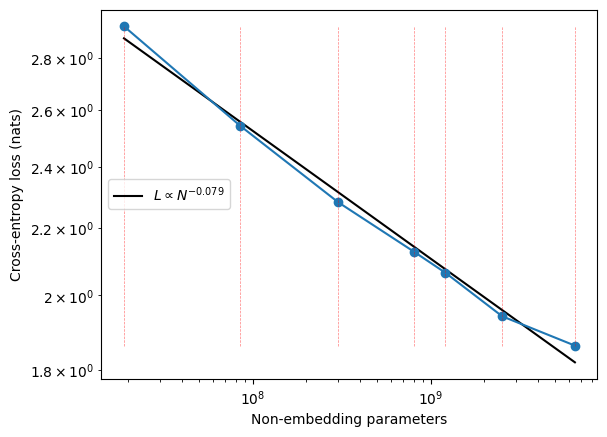

In [5]:
curve_means = curves.mean(axis=0)
plt.plot(no_emb_params, curve_means, 'o-')
# plt.plot(with_emb_params, curves.mean(axis=0))
for model_name in model_names[:-1]:
    plt.plot([sizes[model_name][0]]*2, [min(curve_means), max(curve_means)], color='red', linestyle='dashed', linewidth=0.5, alpha=0.5)

reg = LinearRegression().fit(np.log(no_emb_params).reshape(-1, 1), np.log(curve_means))
reg_ys = np.exp(reg.intercept_) * np.power(no_emb_params, reg.coef_[0])
plt.plot(no_emb_params, reg_ys, color='black', zorder=-10, label=f"$L\propto N^{{{reg.coef_[0]:.3f}}}$")

plt.yscale('log')
plt.xscale('log')
plt.xlabel("Non-embedding parameters")
plt.ylabel("Cross-entropy loss (nats)")
plt.legend()

In [7]:
curves_new = np.load("/om/user/ericjm/results/the-everything-machine/pythia-1/pythia-1.npy")

In [8]:
curves_new.shape

(10658635, 7)

In [9]:
curves.shape

(1605311, 7)

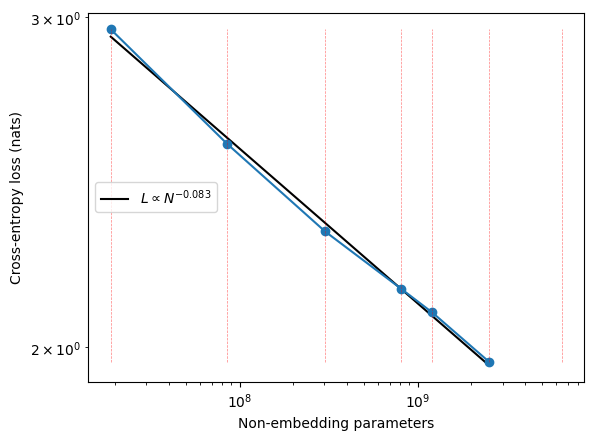

In [17]:
curve_means = curves_new[:, :-1].mean(axis=0)
plt.plot(no_emb_params[:-1], curve_means, 'o-')
# plt.plot(with_emb_params, curves_new.mean(axis=0))
for model_name in model_names[:-1]:
    plt.plot([sizes[model_name][0]]*2, [min(curve_means), max(curve_means)], color='red', linestyle='dashed', linewidth=0.5, alpha=0.5)

reg = LinearRegression().fit(np.log(no_emb_params[:-1]).reshape(-1, 1), np.log(curve_means))
reg_ys = np.exp(reg.intercept_) * np.power(no_emb_params[:-1], reg.coef_[0])
plt.plot(no_emb_params[:-1], reg_ys, color='black', zorder=-10, label=f"$L\propto N^{{{reg.coef_[0]:.3f}}}$")

plt.yscale('log')
plt.xscale('log')
plt.xlabel("Non-embedding parameters")
plt.ylabel("Cross-entropy loss (nats)")
plt.legend()

In [29]:
i = 12345
print(curves[i])
print(curves_new[i])

[0.24845433 0.21921836 0.29074648 0.29101661 0.25413761 0.19857149
 0.26100293]
[0.24845433 0.21921836 0.29074648 0.29101661 0.25413761 0.19857149
 0.26100293]
